In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline


In [2]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 32)
        self.out = nn.Linear(32, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

In [3]:
torch.manual_seed(41)
model = Model()


In [4]:
my_df = pd.read_csv('data.csv')

In [5]:
my_df['metric'] = my_df['metric'].replace({
    'Schwarzschild': 0,
    'Kerr': 1,
    'Kerr_Newman': 2,
    'Reissner_Nordstrom': 3
})
my_df

C:\Users\Mukul\AppData\Local\Temp\ipykernel_12576\1461663101.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  my_df['metric'] = my_df['metric'].replace({


,radius,value,metric
0,340.515162,0.642382,0
1,497.356315,0.773223,0
2,396.673379,0.704136,0
3,489.919703,0.769266,0
4,452.142898,0.746768,0
...,...,...,...
395,498.713972,0.781397,3
396,579.879977,0.810245,3
397,592.594638,0.826884,3
398,321.072330,0.616381,3


In [6]:
X = my_df.drop('metric', axis=1).values
y = my_df['metric'].values.astype(int)

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 41)

In [9]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

In [10]:
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [11]:
class_counts = torch.bincount(y_train)
class_weights = 1.0 / class_counts.float()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [12]:
model.parameters

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=4, bias=True)
)>

In [13]:

epochs = 200
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 1.3983
Epoch 20, Loss: 1.0819
Epoch 40, Loss: 0.9715
Epoch 60, Loss: 0.8673
Epoch 80, Loss: 0.8132
Epoch 100, Loss: 0.7875
Epoch 120, Loss: 0.7600
Epoch 140, Loss: 0.7446
Epoch 160, Loss: 0.7292
Epoch 180, Loss: 0.7167


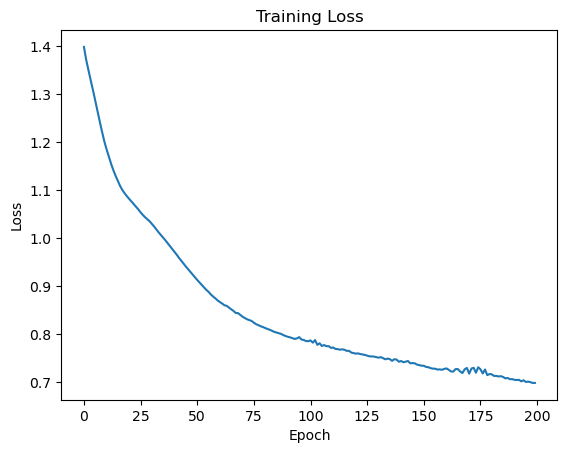

In [14]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [15]:

with torch.no_grad(): 
    y_eval = model.forward(X_test) 
    loss = criterion(y_eval, y_test) 

In [16]:
loss

tensor(0.9399)

In [17]:
model.eval()
correct = 0

label_names = [
    'Schwarzschild',
    'Kerr',
    'Kerr_Newman',
    'Reissner_Nordstrom'
]

with torch.no_grad():
    for i, x in enumerate(X_test):
        logits = model(x.unsqueeze(0))
        pred = logits.argmax(dim=1).item()
        true = y_test[i].item()

        print(f"{i+1}.) True: {label_names[true]} ; Predicted: {label_names[pred]}")
        if pred == true:
            correct += 1

accuracy = correct / len(X_test)*100
print(f"\nAccuracy: {accuracy:.3f}")


1.) True: Reissner_Nordstrom ; Predicted: Reissner_Nordstrom
2.) True: Kerr_Newman ; Predicted: Reissner_Nordstrom
3.) True: Schwarzschild ; Predicted: Schwarzschild
4.) True: Kerr_Newman ; Predicted: Kerr_Newman
5.) True: Kerr ; Predicted: Kerr
6.) True: Kerr ; Predicted: Schwarzschild
7.) True: Kerr ; Predicted: Kerr
8.) True: Reissner_Nordstrom ; Predicted: Reissner_Nordstrom
9.) True: Kerr_Newman ; Predicted: Kerr_Newman
10.) True: Kerr ; Predicted: Kerr
11.) True: Schwarzschild ; Predicted: Schwarzschild
12.) True: Reissner_Nordstrom ; Predicted: Reissner_Nordstrom
13.) True: Kerr_Newman ; Predicted: Kerr_Newman
14.) True: Schwarzschild ; Predicted: Schwarzschild
15.) True: Kerr ; Predicted: Kerr
16.) True: Reissner_Nordstrom ; Predicted: Kerr_Newman
17.) True: Kerr_Newman ; Predicted: Kerr_Newman
18.) True: Schwarzschild ; Predicted: Schwarzschild
19.) True: Reissner_Nordstrom ; Predicted: Reissner_Nordstrom
20.) True: Kerr ; Predicted: Reissner_Nordstrom
21.) True: Kerr_Newman ;

In [18]:
Test = torch.tensor([444.0618887957353, 0.744589387157464])

In [19]:
metric_names = [
    'Schwarzschild',
    'Kerr',
    'Kerr_Newman',
    'Reissner_Nordstrom'
]

probs = torch.softmax(logits, dim=1)

for i, name in enumerate(metric_names):
    print(f"{name}: {probs[0, i]:.2f}")

print("\nFinal predicted metric:", metric_names[probs.argmax().item()])

Schwarzschild: 0.28
Kerr: 0.31
Kerr_Newman: 0.07
Reissner_Nordstrom: 0.34

Final predicted metric: Reissner_Nordstrom
